In [1]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

/Users/Aryan_Goel/intent-classification-model-service/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
clinc_oos = pd.read_csv('../data/clinc_oos.csv')
massive_us_en = pd.read_csv('../data/massive-us-en.csv')

columns = ['utt', 'intent', 'partition']

clinc_oos = clinc_oos[columns]
massive_us_en = massive_us_en[columns]

merged = pd.concat([clinc_oos, massive_us_en], ignore_index=True)
merged['intent'] = merged['intent'].apply(lambda x: x.replace(' ', '_'))
merged['utt'] = merged['utt'].apply(lambda x: x.lower())
merged['utt'] = merged['utt'].apply(lambda x: x.replace('  ', ' '))
merged['utt'] = merged['utt'].apply(lambda x: x.replace('?', ''))
merged['utt'] = merged['utt'].apply(lambda x: x.replace('.', ''))
merged['utt'] = merged['utt'].apply(lambda x: x.replace(',', ''))
merged['utt'] = merged['utt'].apply(lambda x: x.replace('!', ''))
merged['utt'] = merged['utt'].apply(lambda x: x.replace('\'', ''))

merged.to_csv('../data/merged.csv', index=False)

merged.head(100)

,utt,intent,partition
0,set a warning for when my bank account starts ...,oos,oos_val
1,a show on broadway,oos,oos_val
2,who has the best record in the nfl,oos,oos_val
3,how do i find the area of a circle,oos,oos_val
4,how many onions do i have on hand,oos,oos_val
...,...,...,...
95,what does it mean to have equality,oos,oos_val
96,what site publishes the most fake news,oos,oos_val
97,can you tell me some fake news,oos,oos_val
98,is cnn really fake news,oos,oos_val


In [70]:
(merged['partition'].unique().tolist())

['oos_val', 'val', 'oos_test', 'test', 'oos_train', 'train', 'dev']

In [6]:
# Load the merged dataset
merged_dataset = pd.read_csv('../data/merged.csv')

# Encode the labels
labels = merged_dataset['intent'].unique().tolist()
label_map = {label: index for index, label in enumerate(labels)}

# Split the dataset into train, validation, and test
train_data = merged_dataset[merged_dataset['partition'] == 'train']
val_data = merged_dataset[merged_dataset['partition'] == 'val']
test_data = merged_dataset[merged_dataset['partition'] == 'test']


In [7]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encode the training data
train_encodings = tokenizer(train_data['utt'].tolist(), truncation=True, padding=True)
train_labels = torch.tensor([label_map[label] for label in train_data['intent']])
val_encodings = tokenizer(val_data['utt'].tolist(), truncation=True, padding=True)
val_labels = torch.tensor([label_map[label] for label in val_data['intent']])

In [8]:
# Convert lists to tensors
train_input_ids = torch.tensor(train_encodings.input_ids)
train_attention_mask = torch.tensor(train_encodings.attention_mask)
val_input_ids = torch.tensor(val_encodings.input_ids)
val_attention_mask = torch.tensor(val_encodings.attention_mask)
# Create a training dataset
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

In [9]:
# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_map))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [10]:
# Set batch size and create a data loader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# Set optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


/Users/Aryan_Goel/intent-classification-model-service/myenv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [77]:
# Set number of training epochs
num_epochs = 3

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Perform backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct = (predicted_labels == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
    
    average_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Evaluation on the dev set
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_labels = torch.argmax(outputs.logits, dim=1)
            correct = (predicted_labels == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
    
    dev_accuracy = total_correct / total_samples

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Dev Accuracy: {dev_accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), '../models/massive-us-en.pt')


Epoch 1/3 - Loss: 1.8044 - Train Accuracy: 0.6206 - Dev Accuracy: 0.8777
Epoch 2/3 - Loss: 0.3731 - Train Accuracy: 0.8947 - Dev Accuracy: 0.8897
Epoch 3/3 - Loss: 0.1962 - Train Accuracy: 0.9410 - Dev Accuracy: 0.8893


In [11]:
# Testing

test_encodings = tokenizer(test_data['utt'].tolist(), truncation=True, padding=True)
test_labels = torch.tensor([label_map[label] for label in test_data['intent']])
test_input_ids = torch.tensor(test_encodings.input_ids)
test_attention_mask = torch.tensor(test_encodings.attention_mask)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
average_test_loss = test_loss / len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Average Test Loss: {average_test_loss:.4f}")


Test Accuracy: 0.15%
Average Test Loss: 5.3520


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.we

Model: ../models/massive-us-en.pt
              precision    recall  f1-score   support

           1       0.97      0.93      0.95        30
           2       1.00      0.93      0.97        30
           3       0.88      0.97      0.92        30
           4       0.82      0.30      0.44        30
           5       0.93      0.93      0.93        30
           6       1.00      0.90      0.95        30
           7       0.97      1.00      0.98        30
           8       0.97      1.00      0.98        30
           9       0.93      0.93      0.93        30
          10       0.90      0.90      0.90        30
          11       0.93      0.83      0.88        30
          12       1.00      1.00      1.00        30
          13       0.93      0.90      0.92        30
          14       0.86      0.83      0.85        30
          15       0.43      0.33      0.38        30
          16       1.00      1.00      1.00        30
          17       0.94      1.00      0.97    

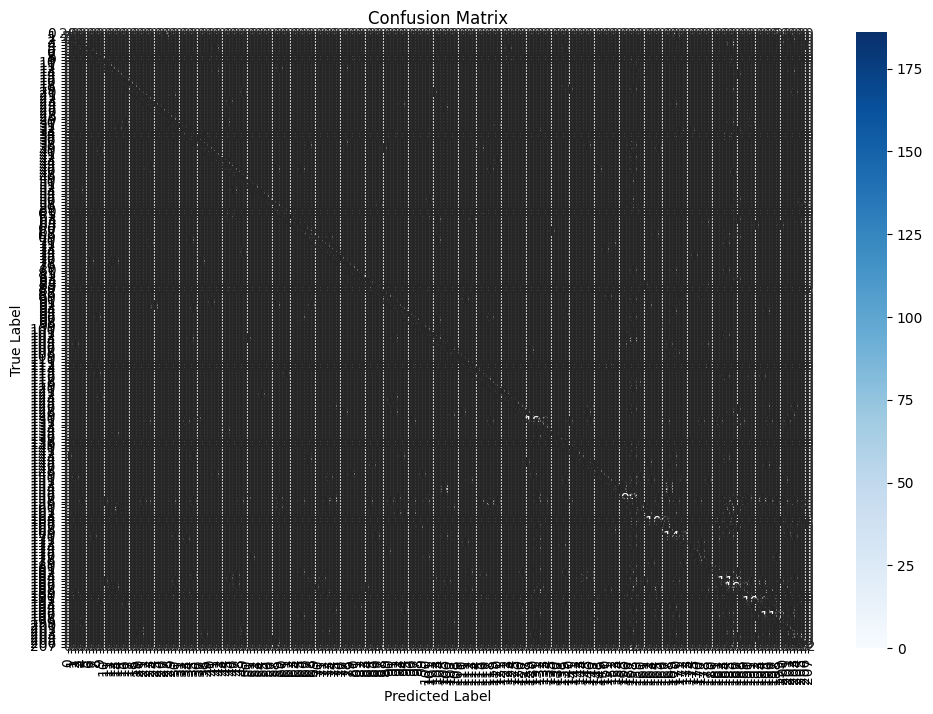

NameError: name 'probs' is not defined

In [12]:
model_path = '../models/massive-us-en.pt'

# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=210)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Evaluate the model
predictions = []
true_labels = []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# Print classification report for Model 1
print(f"Model: {model_path}")
report = classification_report(true_labels, predictions)
print(report)

# Create Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probs, pos_label=1)
auc = roc_auc_score(true_labels, probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Calculate Precision-Recall Curve and Average Precision
precision, recall, thresholds = precision_recall_curve(true_labels, probs, pos_label=1)
ap = average_precision_score(true_labels, probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           1       0.97      0.93      0.95        30
           2       1.00      0.93      0.97        30
           3       0.88      0.97      0.92        30
           4       0.82      0.30      0.44        30
           5       0.93      0.93      0.93        30
           6       1.00      0.90      0.95        30
           7       0.97      1.00      0.98        30
           8       0.97      1.00      0.98        30
           9       0.93      0.93      0.93        30
          10       0.90      0.90      0.90        30
          11       0.93      0.83      0.88        30
          12       1.00      1.00      1.00        30
          13       0.93      0.90      0.92        30
          14       0.86      0.83      0.85        30
          15       0.43      0.33      0.38        30
          16       1.00      1.00      1.00        30
          17       0.94      1.00      0.97        30
          18       1.00    

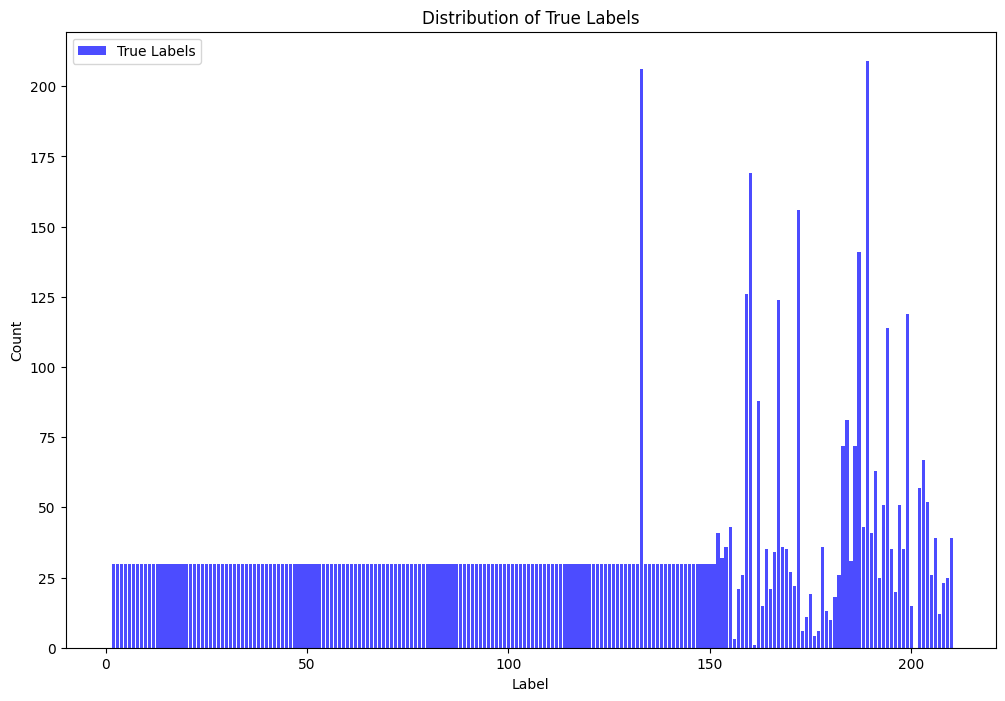

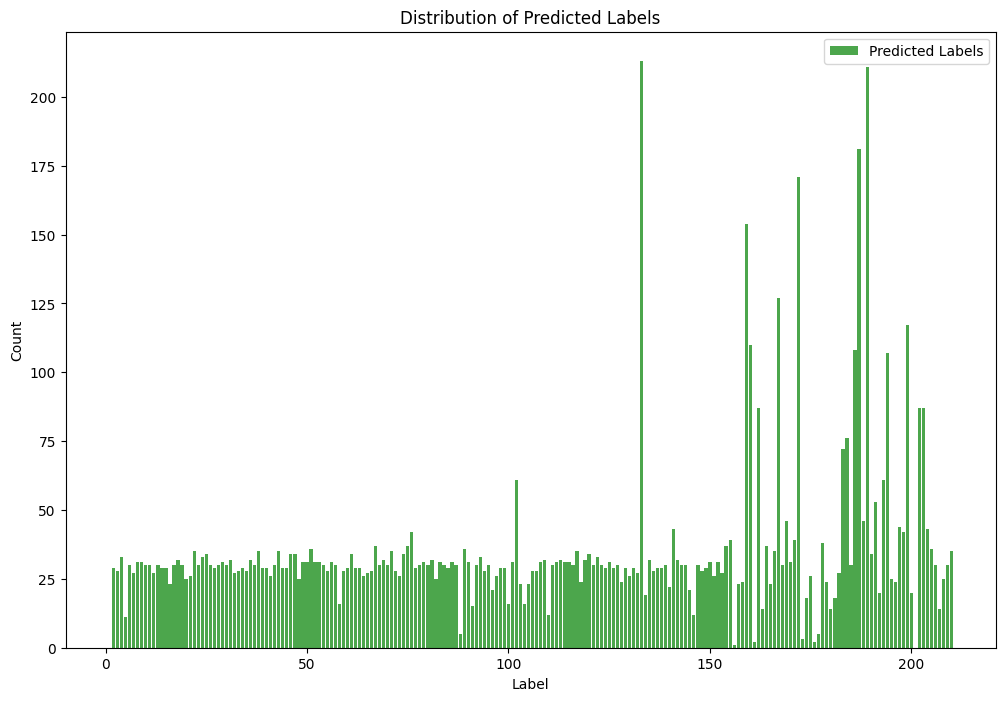

AxisError: axis 1 is out of bounds for array of dimension 1

In [15]:
# Evaluate the model
predictions = []
true_labels = []
probs = []  # Store probabilities for ROC and precision-recall curves

model.eval()

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        probabilities = torch.softmax(outputs.logits, dim=1)  # Calculate class probabilities

        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        probs.extend(probabilities.cpu().tolist())

# Convert the probabilities to a numpy array
probs = np.array(probs)

# Print classification report
report = classification_report(true_labels, predictions)
print(report)

# Create Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Count the occurrences of true labels and predicted labels
true_label_counts = np.bincount(true_labels)
predicted_label_counts = np.bincount(predictions)

# Get the unique labels
labels = np.arange(1, 211)  # Assuming labels range from 1 to 210

# Plot bar chart for true labels
plt.figure(figsize=(12, 8))
plt.bar(labels, true_label_counts, color='blue', alpha=0.7, label='True Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of True Labels')
plt.legend()
plt.show()

# Plot bar chart for predicted labels
plt.figure(figsize=(12, 8))
plt.bar(labels, predicted_label_counts, color='green', alpha=0.7, label='Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.legend()
plt.show()